In [1]:
# load json from file
import json
import pickle
import random
import math
import numpy as np

def loadGame(game):
    with open('./games/'+game+'.json') as f:
        data = json.load(f)
    return data

# with open('./games/tripple.json') as f:
#     data = json.load(f)
# # print the data
# print(data)

games = [
    # loadGame('balloon'),
    # loadGame('riskavoidance'),
    loadGame('double1'),
    loadGame('tripple1'),
    loadGame('tripple2'),
    loadGame('tripple3'),
    loadGame('tripple4'),
]



In [2]:
alpha = 0.1

class Node:
  def __init__(self, node, nodes):
    self.id = pickle.dumps(node)
    self.rewardHistory = []
    self.Vc = 0
    if 'rewards' in node:
      self.rewards = node['rewards']
    if 'actions' not in node:
      self.isLeaf = True
      return
    self.isLeaf = False
    if 'up' in node['actions']:
      self.up = getNode(node['actions']['up'][0]['next'], nodes)
    if 'down' in node['actions']:
      self.down = getNode(node['actions']['down'][0]['next'], nodes)
    if 'left' in node['actions']:
      self.left = getNode(node['actions']['left'][0]['next'], nodes)
    if 'right' in node['actions']:
      self.right = getNode(node['actions']['right'][0]['next'], nodes)

  def __str__(self):
    if self.isLeaf:
      return 'Leaf'
    return 'Node'
  
  def getReward(self):
    # get random number
    r = random.random()
    # sample reward
    s = 0
    if not hasattr(self, 'rewards'):
      return 0
    for i in range(len(self.rewards)):
      s += self.rewards[i]['p']
      if r < s:
        reward = self.rewards[i]['value']
        self.rewardHistory.append(reward)
        self.Vc = self.Vc + alpha * (reward - self.Vc)
        return reward
      
  def getAverageReward(self):
    return sum(self.rewardHistory) / len(self.rewardHistory) if len(self.rewardHistory) > 0 else 0
#    return self.Vc

def getNode(node, nodes):
  # return node in nodes with matching id
  for n in nodes:
    if n.id == pickle.dumps(node):
      return n
  node = Node(node, nodes)
  nodes.append(node)
  return node


In [3]:
class Path:
  def __init__(self, path):
    self.path = path
    self.length = len(path)
    self.taken = 0

  def getReward(self):
    reward = 0
    for node in self.path:
        reward += node.getReward()
    return reward

def getPaths(node, path):
  if node.isLeaf:
    return [Path(path + [node])]
  paths = []
  if hasattr(node, 'left'):
    paths += getPaths(node.left, path + [node])
  if hasattr(node, 'up'):
    paths += getPaths(node.up, path + [node])
  if hasattr(node, 'down'):
    paths += getPaths(node.down, path + [node])
  if hasattr(node, 'right'):
    paths += getPaths(node.right, path + [node])
  return paths

In [4]:
def selectBestPath(paths):
  # select path with highest average reward
  rewards = []
  for path in paths:
    reward = 0
    for node in path.path:
      reward += node.getAverageReward()
    rewards.append(reward)
  # get max from rewards
  bestPath = max(range(len(rewards)), key=rewards.__getitem__)
  return paths[bestPath]

def epsilonGreedy(selectBestPath, epsilon):
  def selectPath(paths):
    # select path with highest average reward
    if random.random() < epsilon:
      return random.choice(paths)
    return selectBestPath(paths)
  return selectPath


In [5]:
def runGame(game, selectPathFunc, warmup=True, warmups=1):
  nodes = []
  start = Node(game['start'], nodes)
  paths = getPaths(start, [])

  score = 0
  for i in range(75):
      if warmup and i < len(paths) * warmups:
        path = paths[i % len(paths)]
      else:
        selectPath = selectPathFunc(i)
        # shuffle paths
        random.shuffle(paths)
        # select path
        path = selectPath(paths)
        path.taken += 1
      # traverse path to update reward
      reward = 0
      for node in path.path:
          reward += node.getReward()
      score += reward

  return score


In [6]:
# calculate expected best path reward

for game in games:
    nodes = []
    start = Node(game['start'], nodes)
    paths = getPaths(start, [])

    for i in range(100000):
        for path in paths:
            path.history = [] if not hasattr(path, 'history') else path.history
            path.history.append(path.getReward())

    expectedPathReward = [sum(path.history)/len(path.history) for path in paths]
    pathRewardVariances = [np.var(path.history) for path in paths]

    expectedPathReward, pathRewardVariances
    game['expectedBest'] = 75 * max(expectedPathReward)
    print(expectedPathReward)
    print(pathRewardVariances)

[game['expectedBest'] for game in games]

[-0.50667, 2.00043, 1.49832]
[3.2519955111000005, 0.6632298151, 3.9324571776]
[1.0, 2.0, 3.0]
[0.0, 0.0, 0.0]
[1.00074, 1.00272, 0.9948]
[0.9999994524000001, 0.6673126015999999, 1.9947729599999997]
[2.0007, 1.49815, 0.99606]
[1.50299951, 0.9220765774999999, 1.9960444763999994]
[3.00338, 1.99486, 2.49703, 1.49747, 1.99851, 1.50697]
[3.4975085756000004, 1.4938335804000002, 1.7538911791, 0.9226935990999998, 1.1644677798999998, 2.2475314191]


[150.03225, 225.0, 75.20400000000001, 150.0525, 225.2535]

In [27]:
results = []


# Epsilon greedy

Game 0
Max score: 0.9815223060375352 at epsilon: 0.0
Game 1
Max score: 0.8950666666666666 at epsilon: 0.15
Game 2
Max score: 1.0358491569597361 at epsilon: 0.91
Game 3
Max score: 0.9102147581679746 at epsilon: 0.13
Game 4
Max score: 0.8405640755859509 at epsilon: 0.12
Average max score: 0.9057762628133489 at epsilon: 0.15


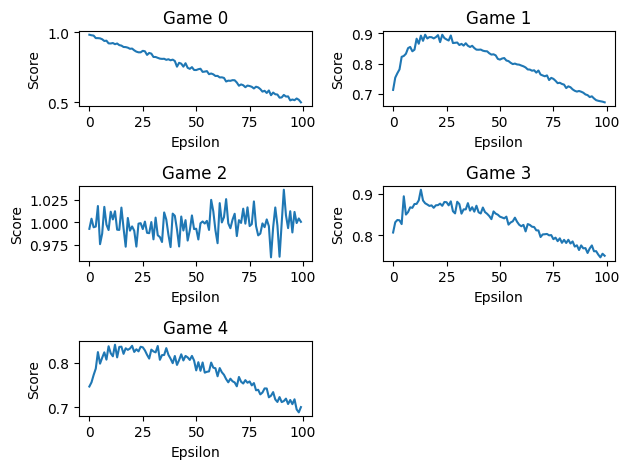

In [28]:
epsilonSteps = 1
alpha = 0.999
def runEpsilonGreedySimulation(game):
    epsilonScores = []
    for epsilon in range(0, 100, epsilonSteps):
        scores = []
        for i in range(100):
            score = runGame(game, lambda x:epsilonGreedy(selectBestPath, epsilon/100.), False)
            scores.append(score)

        avgScore = sum(scores) / len(scores)
        # print(str(epsilon) + ' Score: ' + str(avgScore))
        epsilonScores.append(avgScore)
    return epsilonScores

allScores = []
import matplotlib.pyplot as plt
# run simulation and plot in a grid
for i in range(0,len(games)):
    print('Game ' + str(i))
    epsilonScores = [x/games[i]['expectedBest'] for x in runEpsilonGreedySimulation(games[i])]
    # get max score index
    maxScoreIndex = epsilonScores.index(max(epsilonScores))
    allScores.append(epsilonScores)
    # print max score
    print('Max score: ' + str(epsilonScores[maxScoreIndex]) + ' at epsilon: ' + str(maxScoreIndex*epsilonSteps/100.0))
    plt.subplot(3, 2, i+1)
    # add margin between plots
    plt.subplots_adjust(hspace=0.5)
    plt.title('Game ' + str(i))
    plt.plot(range(0, 100, epsilonSteps), epsilonScores)
    plt.xlabel('Epsilon')
    plt.ylabel('Score')
    # tight fit
    plt.tight_layout()

avgMaxScores = [sum([allScores[j][i] for j in range(len(games))]) / len(games) for i in range(len(allScores[0]))]
# argmax of avgMaxScores
maxScoreIndex = avgMaxScores.index(max(avgMaxScores))
print(f'Average max score: {max(avgMaxScores)} at epsilon: {maxScoreIndex*epsilonSteps/100.0}')

results.append([allScores[i][maxScoreIndex] for i in range(len(games))])


# Epsilon First

Game 0
Max score: 0.9831886144478936 at i: 2
Game 1
Max score: 0.9612444444444445 at i: 6
Game 2
Max score: 1.0225519919153236 at i: 22
Game 3
Max score: 0.9342063611069459 at i: 11
Game 4
Max score: 0.8757244615510968 at i: 14
Average max score: 0.9316758720818203 at epsilon: 0.1


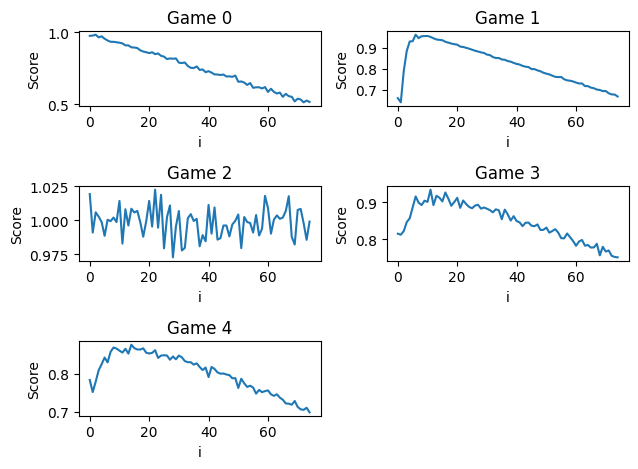

In [29]:
alpha = 0.999

def runEpsilonFirstSimulation(game):
    epsilonScores = []
    for epsilon in range(0, 75, 1):
        scores = []
        for i in range(100):
            score = runGame(game, lambda x:epsilonGreedy(selectBestPath, 1 if x<epsilon else 0), False)
            scores.append(score)

        avgScore = sum(scores) / len(scores)
        # print(str(epsilon) + ' Score: ' + str(avgScore))
        epsilonScores.append(avgScore)
    return epsilonScores

allScores = []
import matplotlib.pyplot as plt
# run simulation and plot in a grid
for i in range(0,len(games)):
    print('Game ' + str(i))
    epsilonScores = [x/games[i]['expectedBest'] for x in runEpsilonFirstSimulation(games[i])]
    # get max score index
    maxScoreIndex = epsilonScores.index(max(epsilonScores))
    allScores.append(epsilonScores)
    # print max score
    print('Max score: ' + str(epsilonScores[maxScoreIndex]) + ' at i: ' + str(maxScoreIndex))
    plt.subplot(3, 2, i+1)
    # add margin between plots
    plt.subplots_adjust(hspace=0.5)
    plt.title('Game ' + str(i))
    plt.plot(range(0, 75, 1), epsilonScores)
    plt.xlabel('i')
    plt.ylabel('Score')
    # tight fit
    plt.tight_layout()

avgMaxScores = [sum([allScores[j][i] for j in range(len(games))]) / len(games) for i in range(len(allScores[0]))]
# argmax of avgMaxScores
maxScoreIndex = avgMaxScores.index(max(avgMaxScores))
print(f'Average max score: {max(avgMaxScores)} at epsilon: {maxScoreIndex*epsilonSteps/100.0}')

results.append([allScores[i][maxScoreIndex] for i in range(len(games))])


# Epsilon Niklas

Game 0
Max score: 0.9739239396863008 at i: 0
Game 1
Max score: 0.9866666666666667 at i: 1
Game 2
Max score: 1.0302643476410829 at i: 69
Game 3
Max score: 0.9183452458306259 at i: 4
Game 4
Max score: 0.8828719642536076 at i: 1
Average max score: 0.9485222621326728 at epsilon: 0.01


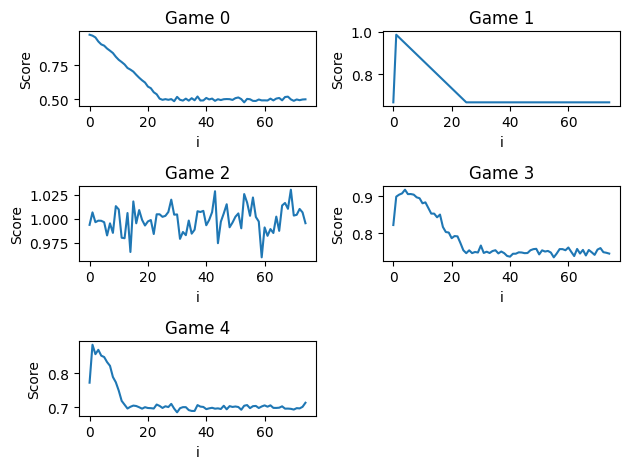

In [30]:
# epislon niklas
alpha = 0.999

def runEpsilonNiklasSimulation(game):
    epsilonScores = []
    for epsilon in range(0, 75, 1):
        scores = []
        for i in range(100):
            score = runGame(game, lambda x:epsilonGreedy(selectBestPath, 0), True, epsilon)
            scores.append(score)

        avgScore = sum(scores) / len(scores)
        # print(str(epsilon) + ' Score: ' + str(avgScore))
        epsilonScores.append(avgScore)
    return epsilonScores

allScores = []
import matplotlib.pyplot as plt
# run simulation and plot in a grid
for i in range(0,len(games)):
    print('Game ' + str(i))
    epsilonScores = [x/games[i]['expectedBest'] for x in runEpsilonNiklasSimulation(games[i])]
    # get max score index
    maxScoreIndex = epsilonScores.index(max(epsilonScores))
    allScores.append(epsilonScores)
    # print max score
    print('Max score: ' + str(epsilonScores[maxScoreIndex]) + ' at i: ' + str(maxScoreIndex))
    plt.subplot(3, 2, i+1)
    # add margin between plots
    plt.subplots_adjust(hspace=0.5)
    plt.title('Game ' + str(i))
    plt.plot(range(0, 75, 1), epsilonScores)
    plt.xlabel('i')
    plt.ylabel('Score')
    # tight fit
    plt.tight_layout()

avgMaxScores = [sum([allScores[j][i] for j in range(len(games))]) / len(games) for i in range(len(allScores[0]))]
# argmax of avgMaxScores
maxScoreIndex = avgMaxScores.index(max(avgMaxScores))
print(f'Average max score: {max(avgMaxScores)} at epsilon: {maxScoreIndex*epsilonSteps/100.0}')

results.append([allScores[i][maxScoreIndex] for i in range(len(games))])


# Softmax


In [31]:
beta = 20

def softmaxSelect(i):
    def selectPath(paths):
        # select path with highest average reward
        rewards = []
        for path in paths:
            reward = 0
            for node in path.path:
                reward += node.getAverageReward()
            rewards.append(reward * beta)

        soft = np.exp(rewards) / np.sum(np.exp(rewards))
        bestPath = np.random.choice(range(len(paths)), p=soft)
        return paths[bestPath]
    return selectPath

def runSoftmaxSimulation(game):
    scores = []
    for i in range(100):
        score = runGame(game, softmaxSelect)
        scores.append(score)

    avgScore = sum(scores) / len(scores)
    return avgScore

# run simulation and plot in a grid
scores = []
for i in range(0,len(games)):
    print('Game ' + str(i))
    score = runSoftmaxSimulation(games[i]) / games[i]['expectedBest']
    scores.append(score)
    print('Score: ' + str(score))

print('Average score for all games: ' + str(np.average(scores)))

results.append(scores)


Game 0
Score: 0.9683917957639107
Game 1
Score: 0.9866666666666667
Game 2
Score: 0.9926333705653955
Game 3
Score: 0.878225954249346
Game 4
Score: 0.8552142364047617
Average score for all games: 0.9362264047300162


# UCB

In [32]:
def ucb1(i):
    def selectPath(paths):
        # select path with highest average reward
        rewards = []
        for path in paths:
            reward = 0
            for node in path.path:
                reward += node.getAverageReward()
            rewards.append(reward)
        highestAverageReward = max(1, max(rewards))
        for i, (reward, path) in enumerate(zip(rewards, paths)):
            # pathVisits = path.taken + 1
            # pathVisits = sum([len(p.rewardHistory) for p in path.path])/len(path.path)
            pathVisits = max([len(p.rewardHistory) for p in path.path]) + 1
            experienceFactor = math.sqrt(2 * math.log(i+1)/pathVisits)
            rewards[i] = reward/highestAverageReward + experienceFactor

        # rewards = [rewards[i]/highestAverageReward + math.sqrt(2*math.log(i+1)/(paths[i].taken if paths[i].taken > 0 else 1)) for i in range(len(rewards))]
        # get max from rewards
        bestPath = max(range(len(rewards)), key=rewards.__getitem__)
        return paths[bestPath]
    return selectPath

def runUCB1Simulation(game):
    scores = []
    for i in range(100):
        score = runGame(game, ucb1)
        scores.append(score)

    avgScore = sum(scores) / len(scores)
    return avgScore



In [33]:
alpha = 0.999

# run simulation and plot in a grid
scores = []
for i in range(0,len(games)):
    print('Game ' + str(i))
    score = runUCB1Simulation(games[i]) / games[i]['expectedBest']
    scores.append(score)
    print('Score: ' + str(score))

print('Average score for all games: ' + str(np.average(scores)))

results.append(scores)


Game 0
Score: 0.9477295714754661
Game 1
Score: 0.9686666666666666
Game 2
Score: 0.998484123184937
Game 3
Score: 0.8927542026957231
Game 4
Score: 0.8635159942020878
Average score for all games: 0.934230111644976


([<matplotlib.axis.XTick at 0x127e01b80>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

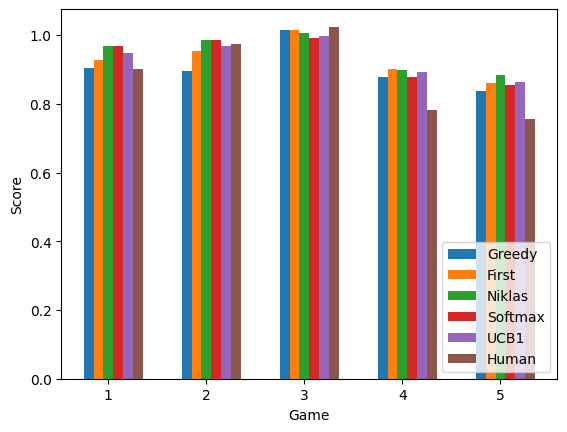

In [45]:
# plot results
import matplotlib.pyplot as plt
import numpy as np

# plot results as bar chart
# plt.figure(figsize=(10, 5))
plt.xlabel('Game')
plt.ylabel('Score')
# plt.bar(['Greedy', 'First', 'Niklas', 'Softmax', 'UCB1'], [np.average(results[i]) for i in range(len(results))])
plt.bar(np.arange(5)-0.2, results[0], width=0.1)
plt.bar(np.arange(5)-0.1, results[1], width=0.1)
plt.bar(range(5), results[2], width=0.1)
plt.bar(np.arange(5)+0.1, results[3], width=0.1)
plt.bar(np.arange(5)+0.2, results[4], width=0.1)
plt.bar(np.arange(5)+0.3, results[5], width=0.1)

# add legend
plt.legend(['Greedy', 'First', 'Niklas', 'Softmax', 'UCB1', 'Human'], loc='lower right')

# change x label to 1 to 5
plt.xticks(range(5), range(1,6))

- legends
- 1-5
- box plots
- human scores
- plot med total score


In [26]:
results

[[0.9101376537377798,
  0.8996,
  0.9991489814371575,
  0.8697622498792088,
  0.8360802384868604,
  0.809137825048963],
 [0.9430639079264626,
  0.9572444444444445,
  0.9830594117334184,
  0.9256760133953116,
  0.8561021249392351,
  0.9422222222222222],
 [0.9705913228655839,
  0.9866666666666667,
  1.0047337907558107,
  0.8932207060862031,
  0.86644602636585,
  1.0100048811786049],
 [0.9658590069801659,
  0.9866666666666667,
  0.9988830381362693,
  0.8988853901134602,
  0.8543707422970119,
  0.7499656705855015],
 [0.9584605976381745,
  0.9686222222222222,
  1.004999734056699,
  0.891754552573266,
  0.860142017771089,
  0.7461224048258635],
 [0.809137825048963,
  0.9422222222222222,
  1.0100048811786049,
  0.7499656705855015,
  0.7461224048258635]]

In [44]:
# newResults = results

# newResults.append([0.809137825048963,
# 0.9422222222222222,
# 1.0100048811786049,
# 0.7499656705855015,
# 0.7461224048258635])

# newResults

newResults[5] = [0.9006304413089163,
0.9733333333333334,
1.0243311915499327,
0.78054247702153,
0.7557545709258994]
